In [1]:
import os,sys
import numpy as np
from collections import namedtuple
import tqdm
import glob
import math
import random
import inspect
import os.path as osp
from pathlib import Path
import itertools
from itertools import chain
import numpy as np
import pandas as pd
import multiprocessing
import h5py
import matplotlib.pyplot as plt
import numpy as np
import sys, os
from importlib import reload

import torch
import torch.nn as nn
from torch.utils.data import random_split
from torch_geometric.data import Data, DataLoader, DataListLoader
from torch_geometric.nn import EdgeConv, global_mean_pool, DataParallel
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.data import Data,Dataset
from torch_scatter import scatter_mean, scatter
from torch.nn import Sequential as Seq, Linear as Lin, ReLU
from torch_geometric.nn import MetaLayer, EdgeConv, global_mean_pool, DynamicEdgeConv
import h5py

In [2]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('../')))

sys.path.append(os.path.abspath(os.path.join('../../')))
import vande.util.util_plotting as vande_plot
reload(vande_plot)

sys.path.append(os.path.abspath(os.path.join('../../')))
sys.path.append(os.path.abspath(os.path.join('../../DarkFlow/darkflow/')))
import DarkFlow.darkflow.networks.flows as flows

import models_torch.models as models
reload(models)
import models_torch.losses as losses
reload(losses)
import utils_torch.scaler
reload(utils_torch.scaler)
import utils_torch.preprocessing as prepr
import utils_torch.plot_util as plot
reload(plot)
import utils_torch.train_util as train
reload(train)
import graph_data.graph_data as graph_data
reload(graph_data)
import utils_torch.model_summary as summary
reload(summary)




<module 'utils_torch.model_summary' from '/eos/home-n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils_torch/model_summary.py'>

In [3]:
data_dir = '/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/output_models/pytroch/'
dataset = graph_data.GraphDataset(root=data_dir,n_jets=1e3)
save_dir = '/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/output_models/pytroch/input_feats/'
   
use_generator = False
if use_generator:
    validation_split = 0.2
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    if dataset_size > 2:
        split = int(np.floor(validation_split * dataset_size))
    else: 
        split = 1
    print(dataset_size,split)
    random_seed= 1001

    train_subset, val_subset = torch.utils.data.random_split(dataset, [dataset_size - split, split],
                                                             generator=torch.Generator().manual_seed(random_seed))
    print("train subset dim:", len(train_subset))
    print("validation subset dim", len(val_subset))
    dataloaders = {
        'train':  DataLoader(train_subset, batch_size=128, shuffle=True),
        'val':   DataLoader(val_subset, batch_size=128, shuffle=True)
    }
    print("train_dataloader dim:", len(dataloaders['train']))
    print("val dataloader dim:", len(dataloaders['val']))
else : 
    in_memory_datas = dataset.return_inmemory_data_no_loop() 

In [ ]:
pf_cands,jet_prop = dataset.pf_cands,dataset.jet_prop
pf_cands_t = torch.cat([torch.tensor(pf_cands[i], dtype=torch.float) for i in range(len(pf_cands))])
#Plot consistuents and jet features prepared for the graph! (but before any normalization)
pf_feats = 'px,py,pz,E,pt,eta,phi'.split(',')
jet_feats = 'N_constituents,M,Pt,Eta,Phi'.split(',')


save_dir = '/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/output_models/pytroch/input_feats/'
vande_plot.plot_features(pf_cands_t.numpy(), pf_feats ,'Normalized' , 'QCD', plotname='{}plot_pf_feats_{}'.format(save_dir,'QCD_side'), legend=['QCD'], ylogscale=True)
vande_plot.plot_features(jet_prop[:,0:-1], jet_feats ,'Normalized' , 'QCD', plotname='{}plot_jet_feats_{}'.format(save_dir,'QCD_side'), legend=['QCD'], ylogscale=True)


In [4]:
#scaler = standardize(train_subset) # I dont think that this works for the dataset implementation as it is done now, implement scaler as part of dataset ? 
scaler = prepr.standardize(in_memory_datas,minmax_idx=[3,4],log_idx=[3,4]) 

dataloaders = {
    'train':  DataLoader(in_memory_datas, batch_size=128, shuffle=True)
    }
print("train_dataloader dim:", len(dataloaders['train']))

#dataset.get(0).u

train_dataloader dim: 8


In [ ]:
pf_cands_norm = torch.cat([torch.tensor(in_memory_datas[i].x, dtype=torch.float) for i in range(len(in_memory_datas))])
#Plot consistuents and jet features prepared for the graph! (after normalization)
pf_feats = 'px,py,pz,E,pt,eta,phi'.split(',')
save_dir = '/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/output_models/pytroch/input_feats_normalized/'
vande_plot.plot_features(pf_cands_norm.numpy(), pf_feats ,'Normalized' , 'QCD', plotname='{}plot_pf_feats_{}'.format(save_dir,'QCD_side'), legend=['QCD'], ylogscale=True)


In [5]:
torch.manual_seed(0)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
multi_gpu = False #torch.cuda.device_count()>1

In [6]:
# model
input_dim = 7
output_dim = 4#7#4#4,7
big_dim = 32
hidden_dim = 2
#model = models.EdgeNet(input_dim=input_dim,output_dim=output_dim, big_dim=big_dim, hidden_dim=hidden_dim)
#model = models.EdgeNetVAE(input_dim=input_dim,output_dim=output_dim, big_dim=big_dim, hidden_dim=hidden_dim)
model = models.PlanarEdgeNetVAE(input_dim=input_dim,output_dim=output_dim, big_dim=big_dim, hidden_dim=hidden_dim)

optimizer = torch.optim.Adam(model.parameters(), lr = 10e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=4, threshold=1e-6)

model.to(device)
print(model)
summary.gnn_model_summary(model)

PlanarEdgeNetVAE(
  (mu_layer): Linear(in_features=32, out_features=2, bias=True)
  (var_layer): Linear(in_features=32, out_features=2, bias=True)
  (batchnorm): BatchNorm1d(7, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (encoder): EdgeConv(nn=Sequential(
    (0): Linear(in_features=14, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
  ))
  (decoder): EdgeConv(nn=Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=4, bias=True)
  ))
  (amor_u): Linear(in_features=32, out_features=12, bias=True)
  (amor_w): Linear(in_features=32, out_features=12, bias=True)
  (amor_b): Linear(in_features=32, out_features=6, bias=True)
  (flow_0): Planar(
    (h): Tanh()
    (softplus): Softplus(beta=1, threshold=20)
  )
  (flow_1): Planar(
    (h): Tanh()
  

In [7]:
#loss
#loss_ftn_obj = losses.LossFunction('mse_coordinates', device=device)
#loss_ftn_obj = losses.LossFunction('mse', device=device)
#loss_ftn_obj = losses.LossFunction('vae_loss_mse',beta=0.00001,device=device)
loss_ftn_obj = losses.LossFunction('vae_loss_mse_coord',beta=0.5,device=device)

# Training loop
n_epochs = 80
stale_epochs = 0
loss = 999999
#train_losses = []
for epoch in range(0, n_epochs):
    #loss = train(model, optimizer, loader, len(datas), 128, loss_ftn_obj)
    loss_tot,loss_reco,loss_kl = train.train(model, optimizer, dataloaders['train'], len(dataloaders['train'].dataset), dataloaders['train'].batch_size, loss_ftn_obj)
    #train_losses.append(loss)
    print('Epoch: {:02d}, Training Loss Tot, Reco, KL :  {:.4f},{:.4f}, {:.4f}'.format(epoch, loss_tot,loss_reco,loss_kl))

train loss tot = 0.3769287,train loss reco = 0.7467626,train loss kl = 0.0070949: : 8it [00:07,  1.10it/s]                          
train loss tot = 0.3467274,train loss reco = 0.6879418,train loss kl = 0.0055131:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.47it/s]

Epoch: 00, Training Loss Tot, Reco, KL :  0.3704,0.7329, 0.0080


train loss tot = 0.2766567,train loss reco = 0.5481275,train loss kl = 0.0051859: : 8it [00:00, 10.65it/s]                          
train loss tot = 0.3017645,train loss reco = 0.5932603,train loss kl = 0.0102688:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.44it/s]

Epoch: 01, Training Loss Tot, Reco, KL :  0.3213,0.6377, 0.0049


train loss tot = 0.2724274,train loss reco = 0.4959134,train loss kl = 0.0489413: : 8it [00:00, 10.66it/s]                          
train loss tot = 0.2602828,train loss reco = 0.4916580,train loss kl = 0.0289076:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.45it/s]

Epoch: 02, Training Loss Tot, Reco, KL :  0.2851,0.5493, 0.0209


train loss tot = 0.2813617,train loss reco = 0.5041196,train loss kl = 0.0586037: : 8it [00:00, 10.64it/s]                          
train loss tot = 0.2524835,train loss reco = 0.4653557,train loss kl = 0.0396114:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.41it/s]

Epoch: 03, Training Loss Tot, Reco, KL :  0.2810,0.5194, 0.0425


train loss tot = 0.2756721,train loss reco = 0.5261360,train loss kl = 0.0252082: : 8it [00:00, 10.65it/s]                          
train loss tot = 0.2794035,train loss reco = 0.5300635,train loss kl = 0.0287435:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.47it/s]

Epoch: 04, Training Loss Tot, Reco, KL :  0.2673,0.4955, 0.0391


train loss tot = 0.2332686,train loss reco = 0.4517551,train loss kl = 0.0147820: : 8it [00:00, 10.65it/s]                          
train loss tot = 0.2163248,train loss reco = 0.4178711,train loss kl = 0.0147784:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.49it/s]

Epoch: 05, Training Loss Tot, Reco, KL :  0.2440,0.4638, 0.0242


train loss tot = 0.1954689,train loss reco = 0.3841840,train loss kl = 0.0067539: : 8it [00:00, 10.68it/s]                          
train loss tot = 0.2000265,train loss reco = 0.3938277,train loss kl = 0.0062252:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.49it/s]

Epoch: 06, Training Loss Tot, Reco, KL :  0.2200,0.4291, 0.0108


train loss tot = 0.2332443,train loss reco = 0.4572622,train loss kl = 0.0092264: : 8it [00:00, 10.68it/s]                          
train loss tot = 0.2023058,train loss reco = 0.3958270,train loss kl = 0.0087846:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.43it/s]

Epoch: 07, Training Loss Tot, Reco, KL :  0.2035,0.3994, 0.0076


train loss tot = 0.2076511,train loss reco = 0.4102835,train loss kl = 0.0050187: : 8it [00:00, 10.66it/s]                          
train loss tot = 0.1974423,train loss reco = 0.3904154,train loss kl = 0.0044692:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.48it/s]

Epoch: 08, Training Loss Tot, Reco, KL :  0.1973,0.3866, 0.0079


train loss tot = 0.1626115,train loss reco = 0.3155310,train loss kl = 0.0096921: : 8it [00:00, 10.67it/s]                          
train loss tot = 0.1844046,train loss reco = 0.3529925,train loss kl = 0.0158168:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.45it/s]

Epoch: 09, Training Loss Tot, Reco, KL :  0.1928,0.3803, 0.0053


train loss tot = 0.1945860,train loss reco = 0.3746178,train loss kl = 0.0145543: : 8it [00:00, 10.66it/s]                          
train loss tot = 0.1780155,train loss reco = 0.3422994,train loss kl = 0.0137316:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.49it/s]

Epoch: 10, Training Loss Tot, Reco, KL :  0.1918,0.3689, 0.0146


train loss tot = 0.1615797,train loss reco = 0.3116145,train loss kl = 0.0115450: : 8it [00:00, 10.67it/s]                          
train loss tot = 0.1669219,train loss reco = 0.3248330,train loss kl = 0.0090107:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.39it/s]

Epoch: 11, Training Loss Tot, Reco, KL :  0.1878,0.3646, 0.0110


train loss tot = 0.1833413,train loss reco = 0.3608467,train loss kl = 0.0058358: : 8it [00:00, 10.64it/s]                          
train loss tot = 0.1824910,train loss reco = 0.3603919,train loss kl = 0.0045900:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.54it/s]

Epoch: 12, Training Loss Tot, Reco, KL :  0.1787,0.3508, 0.0065


train loss tot = 0.1624734,train loss reco = 0.3159438,train loss kl = 0.0090030: : 8it [00:00, 10.68it/s]                          
train loss tot = 0.1877539,train loss reco = 0.3498789,train loss kl = 0.0256288:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.52it/s]

Epoch: 13, Training Loss Tot, Reco, KL :  0.1749,0.3447, 0.0052


train loss tot = 0.2134411,train loss reco = 0.3752503,train loss kl = 0.0516320: : 8it [00:00, 10.68it/s]                          
train loss tot = 0.1788613,train loss reco = 0.3173305,train loss kl = 0.0403920:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.49it/s]

Epoch: 14, Training Loss Tot, Reco, KL :  0.1993,0.3567, 0.0419


train loss tot = 0.1521012,train loss reco = 0.2876173,train loss kl = 0.0165850: : 8it [00:00, 10.68it/s]                          
train loss tot = 0.1238874,train loss reco = 0.2335250,train loss kl = 0.0142498:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.28it/s]

Epoch: 15, Training Loss Tot, Reco, KL :  0.1730,0.3181, 0.0280


train loss tot = 0.1741970,train loss reco = 0.3378862,train loss kl = 0.0105077: : 8it [00:00, 10.53it/s]                          
train loss tot = 0.1765291,train loss reco = 0.3409309,train loss kl = 0.0121274:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.41it/s]

Epoch: 16, Training Loss Tot, Reco, KL :  0.1538,0.2953, 0.0123


train loss tot = 0.1384786,train loss reco = 0.2641897,train loss kl = 0.0127676: : 8it [00:00, 10.50it/s]                          
train loss tot = 0.1508359,train loss reco = 0.2879007,train loss kl = 0.0137711:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.45it/s]

Epoch: 17, Training Loss Tot, Reco, KL :  0.1515,0.2911, 0.0119


train loss tot = 0.1910564,train loss reco = 0.3122769,train loss kl = 0.0698358: : 8it [00:00, 10.68it/s]                          
train loss tot = 0.2081672,train loss reco = 0.2968751,train loss kl = 0.1194593:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.48it/s]

Epoch: 18, Training Loss Tot, Reco, KL :  0.1560,0.2807, 0.0313


train loss tot = 0.2222513,train loss reco = 0.2658573,train loss kl = 0.1786453: : 8it [00:00, 10.71it/s]                          
train loss tot = 0.2127735,train loss reco = 0.2872103,train loss kl = 0.1383366:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.56it/s]

Epoch: 19, Training Loss Tot, Reco, KL :  0.2182,0.2930, 0.1434


train loss tot = 0.1713870,train loss reco = 0.2703378,train loss kl = 0.0724363: : 8it [00:00, 10.71it/s]                          
train loss tot = 0.1664976,train loss reco = 0.2859535,train loss kl = 0.0470416:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.54it/s]

Epoch: 20, Training Loss Tot, Reco, KL :  0.2014,0.2812, 0.1217


train loss tot = 0.1536233,train loss reco = 0.2883349,train loss kl = 0.0189116: : 8it [00:00, 10.73it/s]                          
train loss tot = 0.1332568,train loss reco = 0.2520290,train loss kl = 0.0144846:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.65it/s]

Epoch: 21, Training Loss Tot, Reco, KL :  0.1576,0.2835, 0.0317


train loss tot = 0.1439134,train loss reco = 0.2697953,train loss kl = 0.0180316: : 8it [00:00, 10.76it/s]                          
train loss tot = 0.1399984,train loss reco = 0.2631021,train loss kl = 0.0168947:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.52it/s]

Epoch: 22, Training Loss Tot, Reco, KL :  0.1392,0.2638, 0.0146


train loss tot = 0.1311814,train loss reco = 0.2442588,train loss kl = 0.0181040: : 8it [00:00, 10.72it/s]                          
train loss tot = 0.1247645,train loss reco = 0.2322918,train loss kl = 0.0172372:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.48it/s]

Epoch: 23, Training Loss Tot, Reco, KL :  0.1357,0.2533, 0.0182


train loss tot = 0.1642450,train loss reco = 0.3211341,train loss kl = 0.0073559: : 8it [00:00, 10.73it/s]                          
train loss tot = 0.1396189,train loss reco = 0.2712793,train loss kl = 0.0079584:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.44it/s]

Epoch: 24, Training Loss Tot, Reco, KL :  0.1347,0.2566, 0.0127


train loss tot = 0.1367449,train loss reco = 0.2598119,train loss kl = 0.0136780: : 8it [00:00, 10.51it/s]                          
train loss tot = 0.1785605,train loss reco = 0.3403981,train loss kl = 0.0167229:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.53it/s]

Epoch: 25, Training Loss Tot, Reco, KL :  0.1485,0.2874, 0.0097


train loss tot = 0.1474952,train loss reco = 0.2769294,train loss kl = 0.0180610: : 8it [00:00, 10.74it/s]                          
train loss tot = 0.1723184,train loss reco = 0.3297721,train loss kl = 0.0148648:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.51it/s]

Epoch: 26, Training Loss Tot, Reco, KL :  0.1565,0.2950, 0.0180


train loss tot = 0.1882853,train loss reco = 0.3584450,train loss kl = 0.0181256: : 8it [00:00, 10.70it/s]                          
train loss tot = 0.1777709,train loss reco = 0.3369498,train loss kl = 0.0185920:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.48it/s]

Epoch: 27, Training Loss Tot, Reco, KL :  0.1667,0.3151, 0.0182


train loss tot = 0.1714864,train loss reco = 0.3329639,train loss kl = 0.0100090: : 8it [00:00, 10.73it/s]                          
train loss tot = 0.1290775,train loss reco = 0.2492773,train loss kl = 0.0088776:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.27it/s]

Epoch: 28, Training Loss Tot, Reco, KL :  0.1646,0.3138, 0.0155


train loss tot = 0.1343668,train loss reco = 0.2598143,train loss kl = 0.0089194: : 8it [00:00, 10.42it/s]                          
train loss tot = 0.1394975,train loss reco = 0.2726655,train loss kl = 0.0063296:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.39it/s]

Epoch: 29, Training Loss Tot, Reco, KL :  0.1439,0.2783, 0.0095


train loss tot = 0.1116492,train loss reco = 0.2177112,train loss kl = 0.0055872: : 8it [00:00, 10.62it/s]                          
train loss tot = 0.1545668,train loss reco = 0.3036107,train loss kl = 0.0055228:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.44it/s]

Epoch: 30, Training Loss Tot, Reco, KL :  0.1328,0.2593, 0.0064


train loss tot = 0.1339978,train loss reco = 0.2622502,train loss kl = 0.0057455: : 8it [00:00, 10.62it/s]                          
train loss tot = 0.1207880,train loss reco = 0.2362249,train loss kl = 0.0053510:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.43it/s]

Epoch: 31, Training Loss Tot, Reco, KL :  0.1296,0.2537, 0.0055


train loss tot = 0.1175743,train loss reco = 0.2302748,train loss kl = 0.0048738: : 8it [00:00, 10.66it/s]                          
train loss tot = 0.1097580,train loss reco = 0.2146216,train loss kl = 0.0048945:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.41it/s]

Epoch: 32, Training Loss Tot, Reco, KL :  0.1261,0.2469, 0.0053


train loss tot = 0.1269995,train loss reco = 0.2496786,train loss kl = 0.0043203: : 8it [00:00, 10.66it/s]                          
train loss tot = 0.1180717,train loss reco = 0.2319452,train loss kl = 0.0041983:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.49it/s]

Epoch: 33, Training Loss Tot, Reco, KL :  0.1242,0.2437, 0.0047


train loss tot = 0.1391015,train loss reco = 0.2742571,train loss kl = 0.0039459: : 8it [00:00, 10.69it/s]                          
train loss tot = 0.1168034,train loss reco = 0.2296376,train loss kl = 0.0039691:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.53it/s]

Epoch: 34, Training Loss Tot, Reco, KL :  0.1225,0.2409, 0.0041


train loss tot = 0.1272915,train loss reco = 0.2508183,train loss kl = 0.0037646: : 8it [00:00, 10.72it/s]                          
train loss tot = 0.1472985,train loss reco = 0.2908270,train loss kl = 0.0037700:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.55it/s]

Epoch: 35, Training Loss Tot, Reco, KL :  0.1202,0.2364, 0.0040


train loss tot = 0.1006968,train loss reco = 0.1972837,train loss kl = 0.0041100: : 8it [00:00, 10.71it/s]                          
train loss tot = 0.1069320,train loss reco = 0.2094964,train loss kl = 0.0043676:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.54it/s]

Epoch: 36, Training Loss Tot, Reco, KL :  0.1187,0.2336, 0.0039


train loss tot = 0.1284052,train loss reco = 0.2424600,train loss kl = 0.0143503: : 8it [00:00, 10.70it/s]                          
train loss tot = 0.1329548,train loss reco = 0.2350369,train loss kl = 0.0308727:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.41it/s]

Epoch: 37, Training Loss Tot, Reco, KL :  0.1253,0.2441, 0.0065


train loss tot = 0.1998138,train loss reco = 0.3186238,train loss kl = 0.0810039: : 8it [00:00, 10.62it/s]                          
train loss tot = 0.1968746,train loss reco = 0.3036772,train loss kl = 0.0900720:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.49it/s]

Epoch: 38, Training Loss Tot, Reco, KL :  0.1666,0.2811, 0.0522


train loss tot = 0.1687000,train loss reco = 0.2574573,train loss kl = 0.0799426: : 8it [00:00, 10.64it/s]                          
train loss tot = 0.1797162,train loss reco = 0.2852789,train loss kl = 0.0741536:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.47it/s]

Epoch: 39, Training Loss Tot, Reco, KL :  0.2044,0.3200, 0.0888


train loss tot = 0.1471845,train loss reco = 0.2593832,train loss kl = 0.0349858: : 8it [00:00, 10.65it/s]                          
train loss tot = 0.1575287,train loss reco = 0.2881371,train loss kl = 0.0269203:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.28it/s]

Epoch: 40, Training Loss Tot, Reco, KL :  0.1722,0.2898, 0.0546


train loss tot = 0.1315619,train loss reco = 0.2455742,train loss kl = 0.0175496: : 8it [00:00, 10.56it/s]                          
train loss tot = 0.1583642,train loss reco = 0.3011435,train loss kl = 0.0155849:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.43it/s]

Epoch: 41, Training Loss Tot, Reco, KL :  0.1468,0.2721, 0.0215


train loss tot = 0.1688594,train loss reco = 0.3281743,train loss kl = 0.0095446: : 8it [00:00, 10.60it/s]                          
train loss tot = 0.1313177,train loss reco = 0.2536711,train loss kl = 0.0089643:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.41it/s]

Epoch: 42, Training Loss Tot, Reco, KL :  0.1379,0.2627, 0.0131


train loss tot = 0.1667877,train loss reco = 0.3232851,train loss kl = 0.0102903: : 8it [00:00, 10.62it/s]                          
train loss tot = 0.1909824,train loss reco = 0.3704191,train loss kl = 0.0115457:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.45it/s]

Epoch: 43, Training Loss Tot, Reco, KL :  0.1699,0.3302, 0.0095


train loss tot = 0.1538046,train loss reco = 0.2956086,train loss kl = 0.0120007: : 8it [00:00, 10.61it/s]                          
train loss tot = 0.1402073,train loss reco = 0.2691360,train loss kl = 0.0112786:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.39it/s]

Epoch: 44, Training Loss Tot, Reco, KL :  0.1642,0.3162, 0.0122


train loss tot = 0.1330661,train loss reco = 0.2585418,train loss kl = 0.0075903: : 8it [00:00, 10.60it/s]                          
train loss tot = 0.1596544,train loss reco = 0.3126806,train loss kl = 0.0066281:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.43it/s]

Epoch: 45, Training Loss Tot, Reco, KL :  0.1506,0.2919, 0.0094


train loss tot = 0.1391140,train loss reco = 0.2713845,train loss kl = 0.0068435: : 8it [00:00, 10.61it/s]                          
train loss tot = 0.1199424,train loss reco = 0.2319096,train loss kl = 0.0079752:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.29it/s]

Epoch: 46, Training Loss Tot, Reco, KL :  0.1424,0.2775, 0.0072


train loss tot = 0.1530871,train loss reco = 0.2995252,train loss kl = 0.0066490: : 8it [00:00, 10.55it/s]                          
train loss tot = 0.1247285,train loss reco = 0.2430000,train loss kl = 0.0064570:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.39it/s]

Epoch: 47, Training Loss Tot, Reco, KL :  0.1384,0.2696, 0.0072


train loss tot = 0.1536726,train loss reco = 0.3011431,train loss kl = 0.0062021: : 8it [00:00, 10.63it/s]                          
train loss tot = 0.1311008,train loss reco = 0.2560296,train loss kl = 0.0061721:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.40it/s]

Epoch: 48, Training Loss Tot, Reco, KL :  0.1437,0.2810, 0.0064


train loss tot = 0.1256489,train loss reco = 0.2444891,train loss kl = 0.0068086: : 8it [00:00, 10.61it/s]                          
train loss tot = 0.1364543,train loss reco = 0.2643893,train loss kl = 0.0085193:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.41it/s]

Epoch: 49, Training Loss Tot, Reco, KL :  0.1398,0.2735, 0.0060


train loss tot = 0.1416928,train loss reco = 0.2764773,train loss kl = 0.0069084: : 8it [00:00, 10.50it/s]                          
train loss tot = 0.1130250,train loss reco = 0.2184606,train loss kl = 0.0075894:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.95it/s]

Epoch: 50, Training Loss Tot, Reco, KL :  0.1322,0.2568, 0.0076


train loss tot = 0.1299571,train loss reco = 0.2555754,train loss kl = 0.0043389: : 8it [00:00, 10.54it/s]                          
train loss tot = 0.1344839,train loss reco = 0.2650717,train loss kl = 0.0038960:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.51it/s]

Epoch: 51, Training Loss Tot, Reco, KL :  0.1428,0.2797, 0.0058


train loss tot = 0.1351505,train loss reco = 0.2659813,train loss kl = 0.0043197: : 8it [00:00, 10.72it/s]                          
train loss tot = 0.1281772,train loss reco = 0.2525037,train loss kl = 0.0038507:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.45it/s]

Epoch: 52, Training Loss Tot, Reco, KL :  0.1312,0.2584, 0.0040


train loss tot = 0.1560632,train loss reco = 0.3065686,train loss kl = 0.0055577: : 8it [00:00, 10.70it/s]                          
train loss tot = 0.1359302,train loss reco = 0.2657212,train loss kl = 0.0061393:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.54it/s]

Epoch: 53, Training Loss Tot, Reco, KL :  0.1309,0.2571, 0.0046


train loss tot = 0.1134943,train loss reco = 0.2214290,train loss kl = 0.0055596: : 8it [00:00, 10.65it/s]                          
train loss tot = 0.1164038,train loss reco = 0.2267118,train loss kl = 0.0060958:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.33it/s]

Epoch: 54, Training Loss Tot, Reco, KL :  0.1225,0.2393, 0.0057


train loss tot = 0.1144355,train loss reco = 0.2233941,train loss kl = 0.0054770: : 8it [00:00, 10.54it/s]                          
train loss tot = 0.1111004,train loss reco = 0.2171997,train loss kl = 0.0050011:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.39it/s]

Epoch: 55, Training Loss Tot, Reco, KL :  0.1175,0.2294, 0.0057


train loss tot = 0.1374142,train loss reco = 0.2700419,train loss kl = 0.0047865: : 8it [00:00, 10.59it/s]                          
train loss tot = 0.1482986,train loss reco = 0.2914046,train loss kl = 0.0051925:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.44it/s]

Epoch: 56, Training Loss Tot, Reco, KL :  0.1162,0.2275, 0.0050


train loss tot = 0.0981422,train loss reco = 0.1918069,train loss kl = 0.0044775: : 8it [00:00, 10.62it/s]                          
train loss tot = 0.1137438,train loss reco = 0.2222058,train loss kl = 0.0052818:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.46it/s]

Epoch: 57, Training Loss Tot, Reco, KL :  0.1181,0.2313, 0.0048


train loss tot = 0.1061156,train loss reco = 0.2064328,train loss kl = 0.0057984: : 8it [00:00, 10.60it/s]                          
train loss tot = 0.1042908,train loss reco = 0.2025658,train loss kl = 0.0060157:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.39it/s]

Epoch: 58, Training Loss Tot, Reco, KL :  0.1142,0.2231, 0.0054


train loss tot = 0.1201678,train loss reco = 0.2293593,train loss kl = 0.0109764: : 8it [00:00, 10.52it/s]                          
train loss tot = 0.1261137,train loss reco = 0.2377121,train loss kl = 0.0145153:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.52it/s]

Epoch: 59, Training Loss Tot, Reco, KL :  0.1158,0.2229, 0.0086


train loss tot = 0.1087083,train loss reco = 0.2029311,train loss kl = 0.0144855: : 8it [00:00, 10.70it/s]                          
train loss tot = 0.1181230,train loss reco = 0.2224265,train loss kl = 0.0138194:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.53it/s]

Epoch: 60, Training Loss Tot, Reco, KL :  0.1148,0.2153, 0.0143


train loss tot = 0.1482957,train loss reco = 0.2374874,train loss kl = 0.0591040: : 8it [00:00, 10.70it/s]                          
train loss tot = 0.1340784,train loss reco = 0.2079454,train loss kl = 0.0602114:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.91it/s]

Epoch: 61, Training Loss Tot, Reco, KL :  0.1197,0.2102, 0.0292


train loss tot = 0.1274091,train loss reco = 0.1911778,train loss kl = 0.0636403: : 8it [00:00, 10.34it/s]                          
train loss tot = 0.1325261,train loss reco = 0.1997592,train loss kl = 0.0652930:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.93it/s]

Epoch: 62, Training Loss Tot, Reco, KL :  0.1423,0.2200, 0.0646


train loss tot = 0.1365349,train loss reco = 0.2369368,train loss kl = 0.0361329: : 8it [00:00, 10.34it/s]                          
train loss tot = 0.1408516,train loss reco = 0.2383716,train loss kl = 0.0433316:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.93it/s]

Epoch: 63, Training Loss Tot, Reco, KL :  0.1417,0.2264, 0.0571


train loss tot = 0.1266428,train loss reco = 0.2242779,train loss kl = 0.0290077: : 8it [00:00, 10.34it/s]                          
train loss tot = 0.1107999,train loss reco = 0.1878733,train loss kl = 0.0337264:  13%|█▎        | 1/7.8125 [00:00<00:00,  9.92it/s]

Epoch: 64, Training Loss Tot, Reco, KL :  0.1265,0.2177, 0.0352


train loss tot = 0.1010421,train loss reco = 0.1814843,train loss kl = 0.0205999: : 8it [00:00, 10.61it/s]                          
train loss tot = 0.1055529,train loss reco = 0.1865594,train loss kl = 0.0245464:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.32it/s]

Epoch: 65, Training Loss Tot, Reco, KL :  0.1179,0.2079, 0.0279


train loss tot = 0.1255180,train loss reco = 0.2368024,train loss kl = 0.0142335: : 8it [00:00, 10.55it/s]                          
train loss tot = 0.1186191,train loss reco = 0.2213671,train loss kl = 0.0158711:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.46it/s]

Epoch: 66, Training Loss Tot, Reco, KL :  0.1190,0.2155, 0.0225


train loss tot = 0.1050631,train loss reco = 0.1979374,train loss kl = 0.0121887: : 8it [00:00, 10.60it/s]                          
train loss tot = 0.1039142,train loss reco = 0.1925285,train loss kl = 0.0152999:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.31it/s]

Epoch: 67, Training Loss Tot, Reco, KL :  0.1182,0.2194, 0.0169


train loss tot = 0.1158659,train loss reco = 0.2208592,train loss kl = 0.0108726: : 8it [00:00, 10.57it/s]                          
train loss tot = 0.0888495,train loss reco = 0.1642776,train loss kl = 0.0134214:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.36it/s]

Epoch: 68, Training Loss Tot, Reco, KL :  0.1122,0.2109, 0.0134


train loss tot = 0.1118775,train loss reco = 0.2148104,train loss kl = 0.0089447: : 8it [00:00, 10.58it/s]                          
train loss tot = 0.1070009,train loss reco = 0.2010593,train loss kl = 0.0129425:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.28it/s]

Epoch: 69, Training Loss Tot, Reco, KL :  0.1044,0.1979, 0.0110


train loss tot = 0.0821134,train loss reco = 0.1544564,train loss kl = 0.0097703: : 8it [00:00, 10.55it/s]                          
train loss tot = 0.0919259,train loss reco = 0.1746678,train loss kl = 0.0091841:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.36it/s]

Epoch: 70, Training Loss Tot, Reco, KL :  0.1007,0.1912, 0.0103


train loss tot = 0.0905211,train loss reco = 0.1726761,train loss kl = 0.0083660: : 8it [00:00, 10.48it/s]                          
train loss tot = 0.1011621,train loss reco = 0.1942819,train loss kl = 0.0080424:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.33it/s]

Epoch: 71, Training Loss Tot, Reco, KL :  0.0993,0.1892, 0.0094


train loss tot = 0.1051095,train loss reco = 0.2043487,train loss kl = 0.0058703: : 8it [00:00, 10.61it/s]                          
train loss tot = 0.1258372,train loss reco = 0.2452209,train loss kl = 0.0064536:   0%|          | 0/7.8125 [00:00<?, ?it/s]

Epoch: 72, Training Loss Tot, Reco, KL :  0.1016,0.1964, 0.0067


train loss tot = 0.0953195,train loss reco = 0.1816899,train loss kl = 0.0089490: : 8it [00:00,  9.98it/s]                          
train loss tot = 0.1056584,train loss reco = 0.2018256,train loss kl = 0.0094912:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.38it/s]

Epoch: 73, Training Loss Tot, Reco, KL :  0.1071,0.2063, 0.0080


train loss tot = 0.1158482,train loss reco = 0.2217504,train loss kl = 0.0099460: : 8it [00:00, 10.62it/s]                          
train loss tot = 0.1157321,train loss reco = 0.2226161,train loss kl = 0.0088481:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.43it/s]

Epoch: 74, Training Loss Tot, Reco, KL :  0.1065,0.2039, 0.0091


train loss tot = 0.0920559,train loss reco = 0.1757358,train loss kl = 0.0083761: : 8it [00:00, 10.63it/s]                          
train loss tot = 0.1129206,train loss reco = 0.2167262,train loss kl = 0.0091149:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.46it/s]

Epoch: 75, Training Loss Tot, Reco, KL :  0.1041,0.1993, 0.0089


train loss tot = 0.1026598,train loss reco = 0.1900330,train loss kl = 0.0152865: : 8it [00:00, 10.64it/s]                          
train loss tot = 0.1167987,train loss reco = 0.2211105,train loss kl = 0.0124870:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.47it/s]

Epoch: 76, Training Loss Tot, Reco, KL :  0.1113,0.2115, 0.0111


train loss tot = 0.1162552,train loss reco = 0.2165871,train loss kl = 0.0159232: : 8it [00:00, 10.65it/s]                          
train loss tot = 0.1180531,train loss reco = 0.2216222,train loss kl = 0.0144839:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.43it/s]

Epoch: 77, Training Loss Tot, Reco, KL :  0.1129,0.2118, 0.0140


train loss tot = 0.0948301,train loss reco = 0.1784660,train loss kl = 0.0111941: : 8it [00:00, 10.66it/s]                          
train loss tot = 0.1118604,train loss reco = 0.2092946,train loss kl = 0.0144262:  26%|██▌       | 2/7.8125 [00:00<00:00, 10.51it/s]

Epoch: 78, Training Loss Tot, Reco, KL :  0.1081,0.2042, 0.0120


train loss tot = 0.1131902,train loss reco = 0.2126593,train loss kl = 0.0137212: : 8it [00:00, 10.65it/s]                          

Epoch: 79, Training Loss Tot, Reco, KL :  0.1132,0.2124, 0.0139


In [26]:
reload(utils_torch.scaler)
reload(prepr)
reload(plot)

save_dir = '/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/output_models/pytroch/input_feats/'
inverse_standardization = True
plot.plot_reco_for_loader(model, dataloaders['train'], device, scaler, inverse_standardization, 'test_train', osp.join(save_dir, 'reconstruction_post_train', 'train_reco_std_log_minmax_vae_planar_mseconv_kl_elu'), 'all_mseconv')


In [8]:
latent = plot.gen_latent(model, dataloaders['train'], device)


In [9]:
mu_fts,log_var_fts,z_0_fts,z_last_fts = latent

In [10]:
#!{sys.executable} -m pip install seaborn
#import seaborn as sns


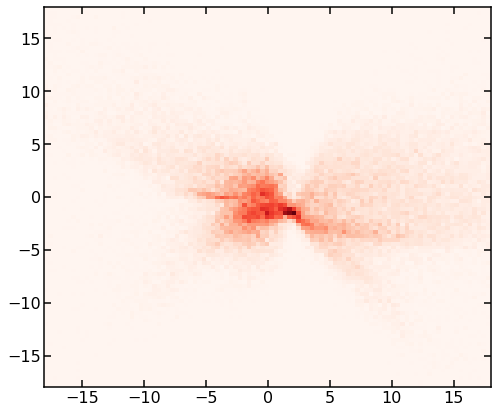

In [11]:
bins = np.linspace(-18,18,100)
plt.hist2d(z_last_fts[:,0].numpy(), y=z_last_fts[:,1].numpy(), bins=(bins, bins), cmap=plt.cm.Reds)
plt.show()

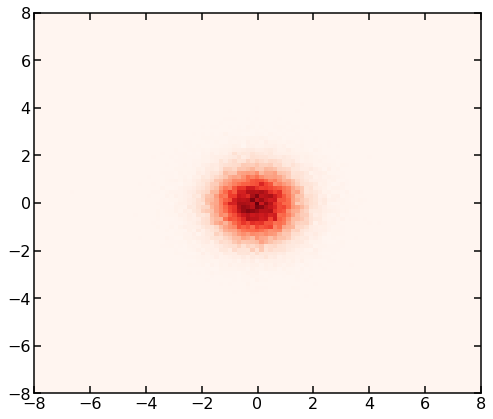

In [12]:
bins = np.linspace(-8,8,100)
plt.hist2d(z_0_fts[:,0].numpy(), y=z_0_fts[:,1].numpy(), bins=(bins, bins), cmap=plt.cm.Reds)
plt.show()

In [13]:
loss_ftn_obj = losses.LossFunction('vae_loss_mse_coord',beta=0.00001,device=device)

loss_tot,loss_reco,loss_kl = train.test(model, dataloaders['train'], len(dataloaders['train'].dataset), dataloaders['train'].batch_size, loss_ftn_obj)

valid loss tot = 0.2198390,valid loss reco = 0.2198410,valid loss kl = 0.0202341: : 8it [00:00, 78.56it/s]                  


In [172]:
for data in dataloaders['train']:
    print(data.edge_index.shape)
    break

torch.Size([2, 389804])


In [9]:
test_loader =  DataLoader(in_memory_datas, batch_size=1, shuffle=True)

In [10]:
jets_losses = []
jets_losses_mse = []
jets_losses_kl = []
for k, data_batch in enumerate(test_loader):
    data_batch.to(device)
    jets_x = data_batch.x
    batch = data_batch.batch
    jets_rec, mu,log_var,_,_,_ = model(data_batch)
    njets = len(torch.unique(batch))
    losses = torch.zeros((njets), dtype=torch.float32)
    losses_mse = torch.zeros((njets), dtype=torch.float32)
    losses_kl = torch.zeros((njets), dtype=torch.float32)
    for ib in torch.unique(batch):
        losses[ib] = loss_ftn_obj.loss_ftn(jets_rec[batch==ib], jets_x[batch==ib], mu, log_var)[0]
        losses_mse[ib] = loss_ftn_obj.loss_ftn(jets_rec[batch==ib], jets_x[batch==ib], mu, log_var)[1]
        losses_kl[ib] = loss_ftn_obj.loss_ftn(jets_rec[batch==ib], jets_x[batch==ib], mu, log_var)[2]
    jets_losses.append(losses)
    jets_losses_mse.append(losses_mse)
    jets_losses_kl.append(losses_kl)

In [11]:
jets_losses = np.array([jets_losses[i].detach().numpy() for i in range(len(jets_losses))]).reshape(-1)
jets_losses_mse = np.array([jets_losses_mse[i].detach().numpy() for i in range(len(jets_losses))]).reshape(-1)
jets_losses_kl = np.array([jets_losses_kl[i].detach().numpy() for i in range(len(jets_losses))]).reshape(-1)

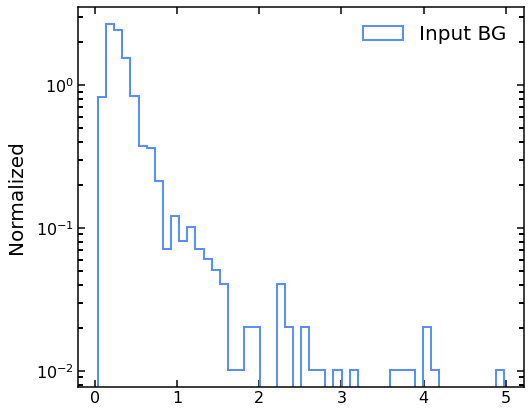

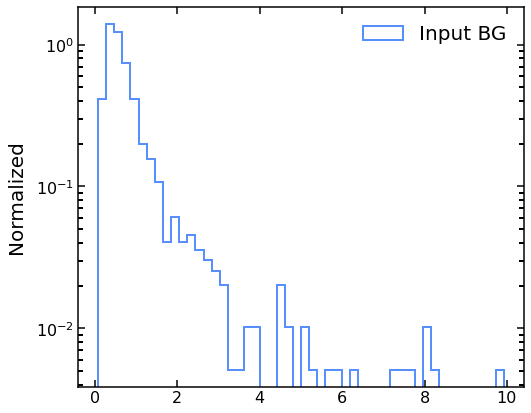

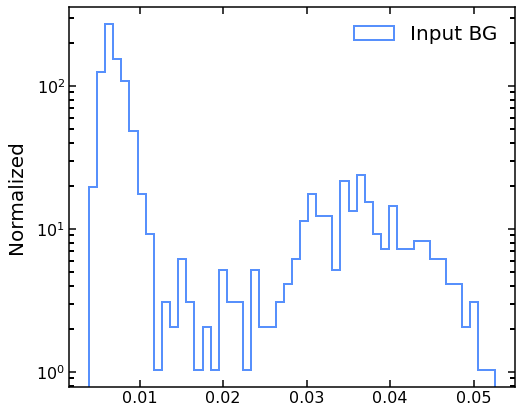

In [33]:
for loss in [jets_losses,jets_losses_mse,jets_losses_kl]:
    xmin = np.quantile(loss,0.05)
    xmax = np.quantile(loss,0.98)
    plt.figure()
    plt.hist(loss, bins=50, label='Input BG', density=True, histtype='step', fill=False, linewidth=2)
    plt.ylabel("Normalized")
    plt.legend(loc='upper right')
    plt.semilogy()
    plt.show()